In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
os.chdir('/Users/walml/repos/morphology-tools')

In [4]:
from ring import bayesian_sim

In [5]:
frac_cols = ['smooth-or-featured_smooth_fraction',
 'smooth-or-featured_featured-or-disk_fraction',
 'smooth-or-featured_artifact_fraction',
 'disk-edge-on_yes_fraction',
 'disk-edge-on_no_fraction',
 'has-spiral-arms_yes_fraction',
 'has-spiral-arms_no_fraction',
 'bar_strong_fraction',
 'bar_weak_fraction',
 'bar_no_fraction',
 'bulge-size_dominant_fraction',
 'bulge-size_large_fraction',
 'bulge-size_moderate_fraction',
 'bulge-size_small_fraction',
 'bulge-size_none_fraction',
 'how-rounded_round_fraction',
 'how-rounded_in-between_fraction',
 'how-rounded_cigar-shaped_fraction',
 'edge-on-bulge_boxy_fraction',
 'edge-on-bulge_none_fraction',
 'edge-on-bulge_rounded_fraction',
 'spiral-winding_tight_fraction',
 'spiral-winding_medium_fraction',
 'spiral-winding_loose_fraction',
 'spiral-arm-count_1_fraction',
 'spiral-arm-count_2_fraction',
 'spiral-arm-count_3_fraction',
 'spiral-arm-count_4_fraction',
 'spiral-arm-count_more-than-4_fraction',
 'spiral-arm-count_cant-tell_fraction',
 'merging_none_fraction',
 'merging_minor-disturbance_fraction',
 'merging_major-disturbance_fraction',
 'merging_merger_fraction']

In [6]:
decals_df = pd.read_parquet(
    '/Users/walml/repos/zoobot_private/gz_decals_auto_posteriors.parquet',
    columns=frac_cols + ['iauname'])

In [7]:
# use vote fractions for now? but selected to fairly high fractions

rare_df = pd.read_parquet('/Users/walml/repos/zoobot/data/rare_features_dr5_with_ml_morph.parquet')
del rare_df['smooth-or-featured_featured-or-disk_fraction']
del rare_df['disk-edge-on_no_fraction']
del rare_df['has-spiral-arms_no_fraction']
rare_df['is_ring'] = rare_df['rare-features_ring_fraction'] > 0.25   # TODO fraction. What the experts say, close enough for now


In [8]:
vote_df = pd.merge(decals_df, rare_df, on='iauname', how='inner')

In [9]:
mobile_df, not_mobile_df = bayesian_sim.select_for_gz_mobile(vote_df, num_galaxies=5000)

In [10]:

mobile_df['ring_votes'] = bayesian_sim.get_fake_mobile_votes(mobile_df['rare-features_ring_fraction'].values)
not_mobile_df['ring_votes'] = bayesian_sim.get_fake_mobile_votes(np.ones(len(not_mobile_df))*0.03)  # assume base rate - TODO could be better

mobile_train_df, mobile_val_df = train_test_split(mobile_df, test_size=0.2)
not_mobile_train_df, not_mobile_val_df = train_test_split(not_mobile_df, test_size=0.2)

train_df = pd.concat([mobile_train_df, not_mobile_train_df[:len(mobile_train_df)]])  # equal size
val_df = pd.concat([mobile_val_df, not_mobile_val_df[:len(mobile_train_df)]])

train_df = train_df.sample(len(train_df))
val_df = val_df.sample(len(val_df))

In [11]:
# frac_cols = [col for col in decals_df.columns.values if col.endswith('_fraction')]
# frac_cols
batch_size = 128

In [12]:
mobile_train_dataset = tf.data.Dataset.from_tensor_slices((train_df[frac_cols], train_df['ring_votes'].astype(np.float32))).batch(batch_size)
mobile_val_dataset = tf.data.Dataset.from_tensor_slices((val_df[frac_cols], val_df['ring_votes'].astype(np.float32))).batch(batch_size)

2021-08-12 11:47:01.862466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
for batch in mobile_train_dataset.take(1):
    print(batch)

(<tf.Tensor: shape=(128, 34), dtype=float64, numpy=
array([[0.45793054, 0.48571591, 0.05635356, ..., 0.13401011, 0.02466206,
        0.0185065 ],
       [0.37188254, 0.55803002, 0.07008743, ..., 0.25720237, 0.06220682,
        0.01774617],
       [0.76758494, 0.16813281, 0.06428225, ..., 0.0730881 , 0.01397686,
        0.01114534],
       ...,
       [0.5245844 , 0.4295314 , 0.0458842 , ..., 0.29476561, 0.08962928,
        0.01975586],
       [0.46677423, 0.47865836, 0.05456741, ..., 0.09126338, 0.01733638,
        0.01442712],
       [0.82613647, 0.09218362, 0.08167992, ..., 0.09123327, 0.01581552,
        0.01184361]])>, <tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 8.,  0.,  0.,  0.,  8.,  7.,  1.,  7.,  5.,  2.,  5.,  0.,  1.,
        0.,  1.,  7.,  1.,  5.,  0.,  0.,  4.,  1.,  7., 10.,  3.,  0.,
        2.,  9.,  0.,  7.,  0.,  0.,  2.,  0.,  5.,  0.,  3.,  7.,  1.,
        1.,  1.,  7.,  1.,  5., 10.,  5., 10.,  0.,  4.,  4.,  6.,  0.,
        0.,  0.,  0.,  0.,  0.,  

In [14]:
# batch[1]

In [15]:
# binomial_loss(batch[1], tf.constant(0.8))

In [17]:

classifier = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(frac_cols))),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
#     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)  # for binomial loss
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid),  # for Dirichlet-Multinomial loss,
    tf.keras.layers.Lambda(lambda x: (x * 100) + 1, output_shape=(2))
])

classifier.compile(
#     loss=bayesian_sim.binomial_loss,
    loss = bayesian_sim.dirichlet_multinomial_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# train to estimate p(ring|votes,voted)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10)

classifier.fit(mobile_train_dataset, validation_data=mobile_val_dataset, epochs=40, callbacks=[early_stopping_callback], verbose=2)

Epoch 1/40


2021-08-12 11:47:12.670442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


63/63 - 1s - loss: 3.7732 - val_loss: 2.8839
Epoch 2/40
63/63 - 0s - loss: 2.9607 - val_loss: 2.1718
Epoch 3/40
63/63 - 0s - loss: 2.3018 - val_loss: 1.7272
Epoch 4/40
63/63 - 0s - loss: 1.9973 - val_loss: 1.5865
Epoch 5/40
63/63 - 0s - loss: 1.9472 - val_loss: 1.5294
Epoch 6/40
63/63 - 0s - loss: 1.9188 - val_loss: 1.4970
Epoch 7/40
63/63 - 0s - loss: 1.9008 - val_loss: 1.4784
Epoch 8/40
63/63 - 0s - loss: 1.8890 - val_loss: 1.4656
Epoch 9/40
63/63 - 0s - loss: 1.8811 - val_loss: 1.4558
Epoch 10/40
63/63 - 0s - loss: 1.8755 - val_loss: 1.4492
Epoch 11/40
63/63 - 0s - loss: 1.8715 - val_loss: 1.4434
Epoch 12/40
63/63 - 0s - loss: 1.8684 - val_loss: 1.4391
Epoch 13/40
63/63 - 0s - loss: 1.8657 - val_loss: 1.4355
Epoch 14/40
63/63 - 0s - loss: 1.8636 - val_loss: 1.4332
Epoch 15/40
63/63 - 0s - loss: 1.8617 - val_loss: 1.4323
Epoch 16/40
63/63 - 0s - loss: 1.8603 - val_loss: 1.4298
Epoch 17/40
63/63 - 0s - loss: 1.8589 - val_loss: 1.4289
Epoch 18/40
63/63 - 0s - loss: 1.8576 - val_loss: 1

In [18]:
print(classifier.evaluate(mobile_val_dataset))

40/40 [==============================] - 0s 915us/step - loss: 1.4159
1.4158855676651


In [19]:
batch[1]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 8.,  0.,  0.,  0.,  8.,  7.,  1.,  7.,  5.,  2.,  5.,  0.,  1.,
        0.,  1.,  7.,  1.,  5.,  0.,  0.,  4.,  1.,  7., 10.,  3.,  0.,
        2.,  9.,  0.,  7.,  0.,  0.,  2.,  0.,  5.,  0.,  3.,  7.,  1.,
        1.,  1.,  7.,  1.,  5., 10.,  5., 10.,  0.,  4.,  4.,  6.,  0.,
        0.,  0.,  0.,  0.,  0.,  8.,  0.,  1.,  1.,  0.,  1.,  6.,  7.,
        6.,  4.,  0.,  0.,  0., 10.,  1.,  4.,  6.,  0.,  7.,  0.,  5.,
        0.,  6.,  0.,  7., 10.,  0.,  8.,  0.,  2.,  0.,  5.,  0., 10.,
        0.,  0.,  3.,  4.,  0.,  7.,  1.,  0.,  0.,  1.,  7.,  0.,  0.,
        6.,  0., 10.,  5.,  1.,  6.,  0.,  4.,  0.,  0.,  0.,  1.,  0.,
        5.,  0.,  0.,  7.,  4.,  8.,  2.,  5.,  4.,  0.,  0.],
      dtype=float32)>

In [20]:
example_preds = classifier.predict(batch[0][:batch_size])[:10]
example_preds

array([[ 5.0393443,  2.113397 ],
       [ 1.0448376,  1.9373456],
       [ 1.2664655,  3.7510047],
       [ 1.3015816,  1.7397771],
       [ 4.271347 ,  2.3017952],
       [ 1.8939892,  1.6112427],
       [ 1.0063146, 19.947235 ],
       [ 5.7286453,  2.201284 ],
       [ 3.8640926,  1.7512629],
       [ 1.09211  ,  4.2417417]], dtype=float32)

In [21]:
def viz_multinomial(concentrations):
    x_votes = np.arange(10)
    votes = np.stack([x_votes, 10-x_votes], axis=1)
    for n, concentration in enumerate(concentrations):
        plt.plot(x_votes, tfp.distributions.DirichletMultinomial(total_count=10, concentration=concentration).prob(votes))
    #     plt.axvline(batch[1][n])

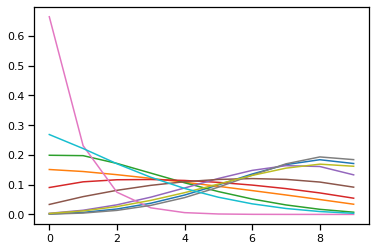

In [22]:
viz_multinomial(example_preds)

In [23]:
# and now calibrate to estimate p(ring)

In [24]:
# unlabelled_df = vote_df.sample(10000)  # to be calibrated
all_preds = classifier.predict(vote_df[frac_cols])

In [25]:

random_expert_labels = vote_df.sample(1000)  # for estimating ring rate in random sample
expert_labelled_rings = random_expert_labels.query('is_ring')
random_expert_ring_preds = classifier.predict(expert_labelled_rings[frac_cols])


expert_labelled_not_rings = random_expert_labels[~random_expert_labels['is_ring']]
random_expert_not_ring_preds = classifier.predict(expert_labelled_not_rings[frac_cols])


In [26]:
random_expert_ring_preds.mean(axis=1)

array([1.8784503, 2.1559649, 1.9136931, 1.7771566, 2.8446627, 1.7724404,
       1.8204445, 4.131996 , 1.547509 , 1.6178781, 1.706315 , 1.5066901,
       2.17203  , 1.5753577, 2.8270552, 1.8842812, 2.171504 , 2.0805845,
       1.6941304, 1.8641064, 2.7792609, 3.3243353, 2.7796783, 2.2305348,
       1.5685866, 1.4927709, 3.303958 , 2.074113 , 1.5716205, 2.9758284,
       1.9729445, 1.5047486, 2.479566 , 5.240752 , 1.8962467, 9.431783 ,
       1.6838753, 2.948194 , 2.7220154, 6.0075355, 6.569892 , 1.6802291,
       2.671128 , 1.9043038, 3.1276698, 1.8945718, 1.5033181, 1.9711967,
       7.3464956, 2.2572856], dtype=float32)

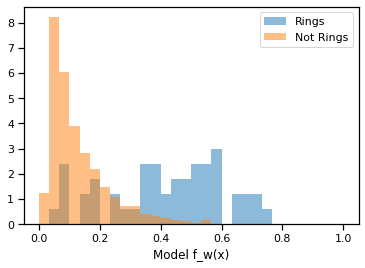

In [51]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(random_preds, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(bayesian_sim.concentrations_to_mean_prob(random_expert_ring_preds), density=True, alpha=.5, label='Rings', bins=viz_bins)
plt.hist(bayesian_sim.concentrations_to_mean_prob(random_expert_not_ring_preds), density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('Model f_w(x)')
plt.legend()

In [57]:

# pred_to_score_func = bayesian_sim.preds_to_sampled_vote
pred_to_score_func = lambda x: bayesian_sim.preds_to_sampled_vote(x, num_samples=1)
bin_edges, bin_centers, ring_rates, not_ring_rates = bayesian_sim.get_fixed_bin_ring_rates(
    random_expert_ring_preds, random_expert_not_ring_preds, pred_to_score_func
)

# pred_to_score_func = bayesian_sim.concentrations_to_mean_prob
# bin_edges, bin_centers, ring_rates, not_ring_rates = bayesian_sim.get_percentile_ring_rates(
#     all_preds, random_expert_ring_preds, random_expert_not_ring_preds, pred_to_score_func
# )

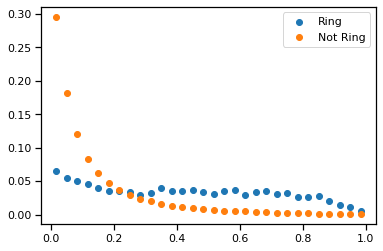

In [58]:
plt.scatter(bin_centers, ring_rates, label='Ring')
plt.scatter(bin_centers, not_ring_rates, label='Not Ring')
plt.legend()

In [54]:
ring_rates

array([0.0628, 0.0554, 0.0412, 0.0482, 0.045 , 0.035 , 0.0374, 0.0362,
       0.0372, 0.0352, 0.0378, 0.0342, 0.0344, 0.0324, 0.035 , 0.0366,
       0.033 , 0.0386, 0.0316, 0.0282, 0.0328, 0.0258, 0.0332, 0.0276,
       0.0286, 0.0254, 0.018 , 0.0164, 0.0102, 0.0066])

In [55]:
not_ring_rates

array([2.95926316e-01, 1.81936842e-01, 1.20515789e-01, 8.38631579e-02,
       6.28210526e-02, 4.55263158e-02, 3.67052632e-02, 2.84736842e-02,
       2.29473684e-02, 1.87894737e-02, 1.61789474e-02, 1.36000000e-02,
       1.11368421e-02, 9.60000000e-03, 7.86315789e-03, 7.46315789e-03,
       6.53684211e-03, 5.34736842e-03, 4.93684211e-03, 4.12631579e-03,
       3.41052632e-03, 3.17894737e-03, 2.35789474e-03, 1.83157895e-03,
       1.61052632e-03, 1.29473684e-03, 9.89473684e-04, 5.36842105e-04,
       3.89473684e-04, 1.05263158e-04])

In [56]:
p_ring = vote_df['is_ring'].mean()

0.053334965217185316

In [68]:
# warning, score func is always concentrations_to_mean_prob
p_ring_given_output = bayesian_sim.scale_probabity_to_random_sample(
    pred_to_score_func(all_preds), ring_rates, not_ring_rates, p_ring, bin_edges
)

In [69]:
# single_prob_per_galaxy = tfp.distributions.Beta(concentration1=all_preds[:, 0], concentration0=all_preds[:, 1]).sample().numpy()

In [70]:
# single_prob_per_galaxy.min(), single_prob_per_galaxy.max()

In [71]:
# p_ring_given_output = bayesian_sim.scale_probabity_to_random_sample(
#     scores=single_prob_per_galaxy,
#     ring_rates=ring_rates,
#     not_ring_rates=not_ring_rates,
#     p_ring=p_ring,
#     bin_edges=bin_edges
# )

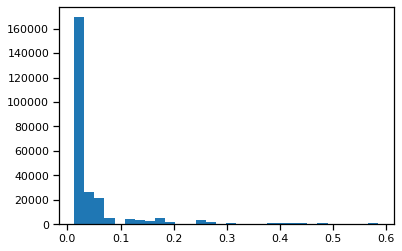

In [72]:
_ = plt.hist(p_ring_given_output, bins=30)

In [73]:
# pd.value_counts(p_ring_given_output)

In [74]:
vote_df['p_ring_given_output'] = p_ring_given_output

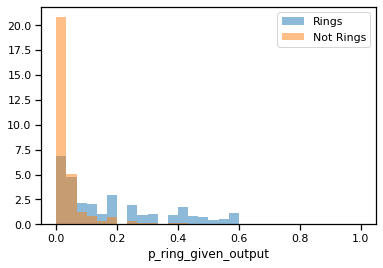

In [75]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(vote_df, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(vote_df.query('is_ring')['p_ring_given_output'], density=True, alpha=.5, label='Rings', bins=viz_bins)
plt.hist(vote_df[~vote_df['is_ring']]['p_ring_given_output'], density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('p_ring_given_output')
plt.legend()

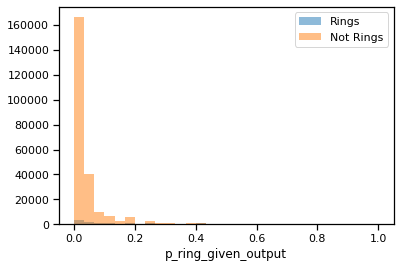

In [76]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(vote_df, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(vote_df.query('is_ring')['p_ring_given_output'], alpha=.5, label='Rings', bins=viz_bins)
plt.hist(vote_df[~vote_df['is_ring']]['p_ring_given_output'], alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('p_ring_given_output')
plt.legend()

In [77]:
likely_ring = vote_df['p_ring_given_output'] > 0.2

vote_df[likely_ring]['is_ring'].mean()  # actual odds that predicted ring is ring

0.37002286525270045

In [78]:
vote_df[likely_ring]['p_ring_given_output'].mean()  # expected odds that predicted ring is ring

0.3681649175455149

In [79]:
# can use the same scaling to adjust the whole curve?

In [80]:
example_preds = all_preds[:10]

In [85]:
def compare_samples_with_calibration(example_pred):
    raw_samples = tfp.distributions.Beta(concentration1=example_pred[0], concentration0=example_pred[1]).sample(50000).numpy()
    p_ring_given_output = bayesian_sim.scale_probabity_to_random_sample(
        raw_samples,
        ring_rates,
        not_ring_rates,
        p_ring,
        bin_edges
    )
    
    num_bins = 50
    plt.hist(raw_samples, bins=num_bins, range=(0, 1), alpha=.5, label='Uncalibrated')
    plt.hist(p_ring_given_output, bins=num_bins, range=(0, 1), alpha=.5, label='Calibrated')
    plt.legend()

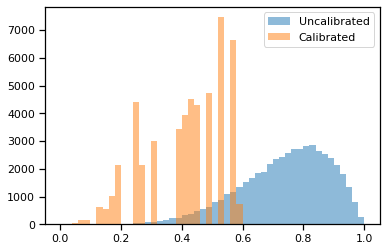

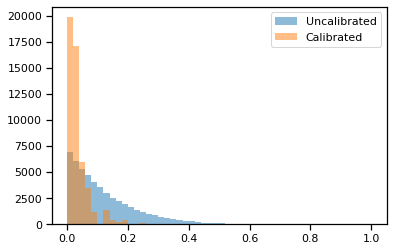

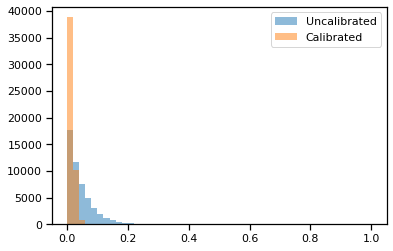

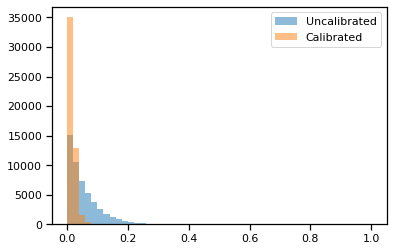

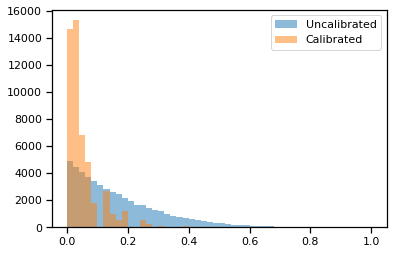

In [86]:
for n in range(5):
    plt.figure()
    compare_samples_with_calibration(example_preds[n])

In [ ]:
assert False

In [ ]:
def estimate_ring_votes(galaxy):
    if galaxy['is_ring']:
        p = galaxy['rare-features_ring_fraction']
    else:
        p = 0.03
    return 10 * p

In [ ]:
# vote_df['fake_ring_votes'] = vote_df.apply(estimate_ring_votes, axis=1)

In [ ]:

for n, concentration in enumerate(all_preds[:10]):
    plt.plot(x_votes, tfp.distributions.DirichletMultinomial(total_count=10, concentration=concentration).prob(votes))
    plt.axvline(estimate_ring_votes(vote_df.iloc[n]), alpha=.2) # probably badly calibrated

In [ ]:
for n, concentration in enumerate(all_preds[:10]):
    uncalibrated_probs = tfp.distributions.DirichletMultinomial(total_count=10, concentration=concentration).prob(votes)
    calibrated_probs = scale_probabity_to_random_sample(uncalibrated_probs, ring_rates, not_ring_rates, p_ring)
    plt.plot(x_votes, calibrated_probs)
    plt.axvline(estimate_ring_votes(vote_df.iloc[n]), alpha=.2)

In [ ]:
tfp.distributions.Beta(concentration1=example_preds[:1, 0], concentration0=example_preds[:1, 1]).sample(10).numpy()

In [ ]:
uncalibrated_probs

In [ ]:
calibrated_probs

In [ ]:
# another method:
# simply adjust p_ring_given_output until empirically calibrated i.e. it actually is a ring as much as it says should be a ring

In [ ]:
# with platt scaling - fit logistic regression to output score to predict is_ring

In [ ]:
# Test twice? i.e. then have volunteers verify